In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datetime import datetime

In [2]:
# Load dataset from Excel
df = pd.read_csv("vanet_syntatic_dataset.csv")  # Replace with your actual file name

# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nClass Distribution:")
print(df["Message_Type"].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          5000 non-null   object 
 1   Vehicle_ID         5000 non-null   object 
 2   Vehicle_Type       5000 non-null   object 
 3   Latitude           5000 non-null   float64
 4   Longitude          5000 non-null   float64
 5   Speed              5000 non-null   float64
 6   Message_Type       5000 non-null   object 
 7   Message_Content    5000 non-null   object 
 8   Weather_Condition  5000 non-null   object 
dtypes: float64(3), object(6)
memory usage: 351.7+ KB
None

First 5 Rows:
  Timestamp  Vehicle_ID Vehicle_Type   Latitude   Longitude       Speed  \
0   21:29.0  vehicle_12        truck  47.623026 -122.387362   30.955655   
1   39:00.8  vehicle_80   motorcycle  47.619424 -122.382836   99.605981   
2   49:31.5  vehicle_95   motorcycle  47.661669 -122.

C:\Users\saiga\AppData\Local\Temp\ipykernel_9608\403153242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Message_Type", data=df, palette="viridis")


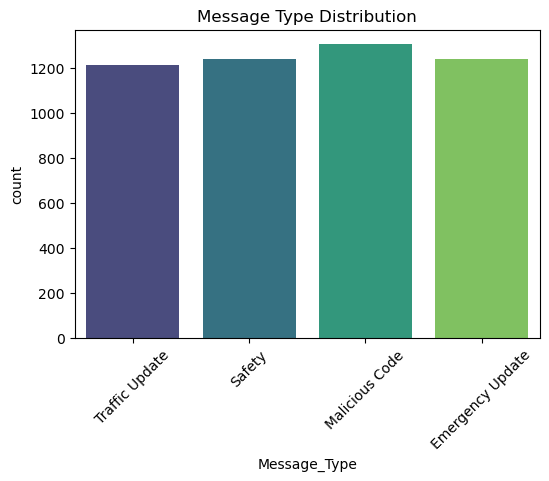

In [3]:
# Plot Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Message_Type", data=df, palette="viridis")
plt.title("Message Type Distribution")
plt.xticks(rotation=45)
plt.show()

In [4]:
# Convert Timestamp to Hour, Minute for time-based analysis
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%M:%S.%f", errors='coerce')
df["Hour"] = df["Timestamp"].dt.hour
df["Minute"] = df["Timestamp"].dt.minute

In [5]:
# Encoding categorical variables
label_enc = LabelEncoder()
df["Vehicle_Type"] = label_enc.fit_transform(df["Vehicle_Type"])
df["Weather_Condition"] = label_enc.fit_transform(df["Weather_Condition"])

In [6]:
# Binning Speed into categories
speed_bins = [0, 30, 60, 100, np.inf]
speed_labels = ['Slow', 'Medium', 'Fast', 'Very Fast']
df["Speed_Category"] = pd.cut(df["Speed"], bins=speed_bins, labels=speed_labels)
df["Speed_Category"] = label_enc.fit_transform(df["Speed_Category"])

In [7]:
# Feature Scaling
scaler = StandardScaler()
df[["Latitude", "Longitude", "Speed"]] = scaler.fit_transform(df[["Latitude", "Longitude", "Speed"]])

In [9]:
import joblib
# Preprocessing: Convert text messages into numerical features
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df["Message_Content"])
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [10]:
# Combine numerical and text features
X = np.hstack((df[["Vehicle_Type", "Latitude", "Longitude", "Speed", "Weather_Condition", "Speed_Category" ]].values, X_text.toarray()))

In [11]:
# Apply Non-overlapped K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
df["Cluster"] = kmeans_labels

In [12]:
# DBSCAN for anomaly detection
dbscan = DBSCAN(eps=1.2, min_samples=3)
dbscan_labels = dbscan.fit_predict(df[["Latitude", "Longitude", "Speed"]])
df["Anomaly"] = (dbscan_labels == -1).astype(int)

In [13]:
# Convert labels to binary (malicious or non-malicious)
df["Label"] = df["Message_Type"].apply(lambda x: 1 if x == "Malicious Code" else 0)

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, df["Label"], test_size=0.2, random_state=42)

In [15]:
# Train SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [16]:
import joblib

# Predictions
y_pred = svm_model.predict(X_test)

# Save the trained SVM model
joblib.dump(svm_model, "ml_model.pkl")

print("Model saved as ml_model.pkl")


Model saved as ml_model.pkl


In [17]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [18]:
# Display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 100.00%
Confusion Matrix:
 [[742   0]
 [  0 258]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       742
           1       1.00      1.00      1.00       258

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



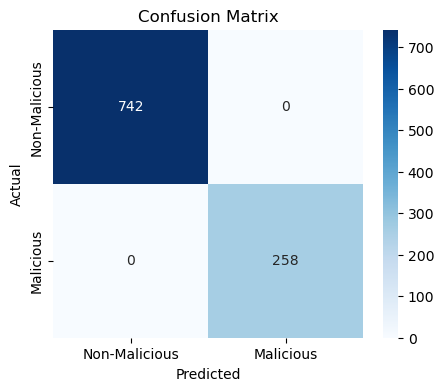

In [19]:
# Visualizing Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Malicious", "Malicious"], yticklabels=["Non-Malicious", "Malicious"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

C:\Users\saiga\AppData\Local\Temp\ipykernel_396\1541825757.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Anomaly", data=df, palette="coolwarm")


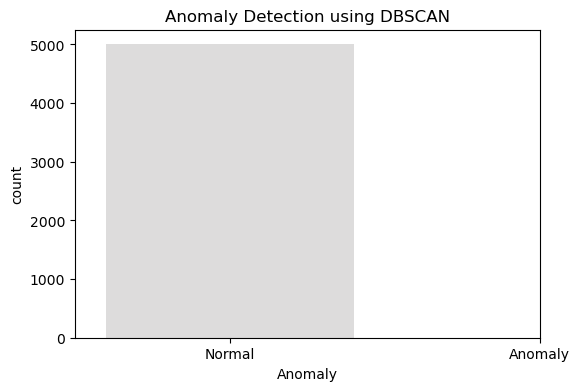

In [28]:
# Plot Anomalies Detected by DBSCAN
plt.figure(figsize=(6,4))
sns.countplot(x="Anomaly", data=df, palette="coolwarm")
plt.title("Anomaly Detection using DBSCAN")
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.show()

In [20]:
from web3 import Web3
import solcx

# Ensure Solidity compiler version matches 0.8.0
solcx.install_solc("0.8.0")
solcx.set_solc_version("0.8.0")

# Connect to local blockchain (Ganache, Hardhat, or Infura)
web3 = Web3(Web3.HTTPProvider("http://127.0.0.1:7545"))

# Confirm connection
assert web3.is_connected(), "Web3 is not connected!"
print(web3.eth.accounts)

['0x85695a577EC8C8d84E7907893121902CAA9BABFC', '0x3FEf5712cA7278f8132056a2B5CB95D5cb4b655b', '0xC8bc93Fe8066A753c253118690Fb90525f287aA9', '0x17CA9800cEfba9a64797a2247CfB171d43723Eb0', '0x44665A2253b662877519d82Abe40849bcf95f8e9', '0x1A290cb2a61602DeD0d5a9b19Dadb69358db920A', '0x14e3C80A4af9208C1551CEB5675eC6533403Af4A', '0xbbdD988dd70c2dC356031d2F5C8714CD86421ada', '0x86dC83f94516049179A638617b4B03242bd49b8a', '0x3D66B2Fb1cf295500373a3d0848445fC72D4cd07']


In [21]:
import solcx
import json

compiled_sol = solcx.compile_files(["MaliciousMessageStorage.sol"], output_values=["abi", "bin"])

# Extract ABI and Bytecode
contract_interface = compiled_sol["MaliciousMessageStorage.sol:MaliciousMessageStorage"]
ABI = contract_interface["abi"]
BYTECODE = contract_interface["bin"]

# Save ABI for later use
with open("MaliciousMessageStorage_abi.json", "w") as abi_file:
    json.dump(ABI, abi_file)

print("ABI saved successfully!")


# Compile Solidity contract
compiled_sol = solcx.compile_files(["MaliciousMessageStorage.sol"], output_values=["abi", "bin"])
contract_interface = compiled_sol["MaliciousMessageStorage.sol:MaliciousMessageStorage"]


# Correctly access contract by key
contract_key = list(compiled_sol.keys())[0]  # First key (adjust if needed)
contract_interface = compiled_sol[contract_key]

# Extract ABI and Bytecode
ABI = contract_interface["abi"]
print(ABI)
BYTECODE = contract_interface["bin"]


ABI saved successfully!
[{'anonymous': False, 'inputs': [{'indexed': False, 'internalType': 'uint256', 'name': 'id', 'type': 'uint256'}, {'indexed': False, 'internalType': 'string', 'name': 'messageType', 'type': 'string'}, {'indexed': False, 'internalType': 'string', 'name': 'messageHash', 'type': 'string'}, {'indexed': False, 'internalType': 'address', 'name': 'sender', 'type': 'address'}], 'name': 'MessageStored', 'type': 'event'}, {'inputs': [], 'name': 'getMaliciousCount', 'outputs': [{'internalType': 'uint256', 'name': '', 'type': 'uint256'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'maliciousMessageCount', 'outputs': [{'internalType': 'uint256', 'name': '', 'type': 'uint256'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'messageCount', 'outputs': [{'internalType': 'uint256', 'name': '', 'type': 'uint256'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [{'internalType': 'uint256', 'name': '', 'type': 'uint25

In [23]:
from_address = web3.eth.accounts[0]  # Use the first account

# Deploy contract
tx_hash = web3.eth.contract(
    abi=ABI,
    bytecode=BYTECODE
).constructor().transact({
    "from": from_address
})

# Wait for deployment
tx_receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
contract_address = tx_receipt.contractAddress

print("Contract deployed at:", contract_address)
#Contract address: 0x7056BED1b0DD2fB744756Bc185DB0b49c269d5D2

Contract deployed at: 0x7056BED1b0DD2fB744756Bc185DB0b49c269d5D2
